In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [4]:
directions = m["direction_YQ1"].flatten() - 1
np.unique(directions)
directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [5]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [6]:
traj_origin.shape

(156, 3, 151)

In [7]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

In [8]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

all_inputs = torch.tensor(traj[:, :, 0], dtype=torch.float32)
all_targets = torch.tensor(traj[:, :, :], dtype=torch.float32)

In [9]:
all_inputs.shape

torch.Size([156, 4])

In [10]:
all_targets.shape

torch.Size([156, 4, 150])

In [11]:
all_targets.swapaxes(1, 2).shape

torch.Size([156, 150, 4])

In [12]:
all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4).shape

torch.Size([156, 1, 4])

In [13]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

hidden_size = 1000
input_size = 4
output_size = 3
lr = 0.0001


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev

model = Net().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 156, hidden_size).cuda()

n_epochs = 1000
losses = list()
for n_epoch in tqdm(range(n_epochs)):
    # x = all_targets.swapaxes(1, 2)
    # give position and target direction [x, y, z, direction] of only first index
    x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
    y = all_targets.swapaxes(1, 2)[:, :, :3]

    output, hidden_prev = model(x.cuda(), hidden_prev)
    hidden_prev = hidden_prev.detach()

    loss = criterion(output, y.cuda())
    model.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().cpu().numpy().item())

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 783.45it/s]


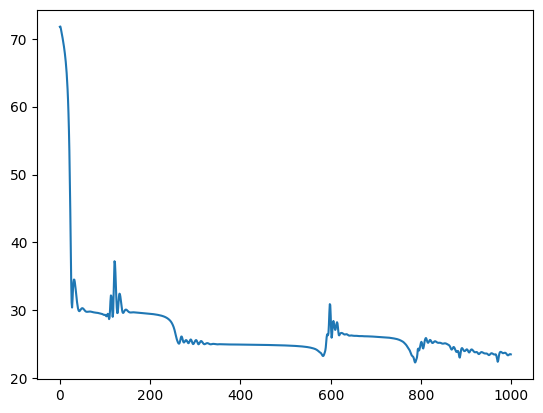

In [14]:
plt.plot(losses)
plt.show()

In [15]:
%matplotlib ipympl

In [16]:
x.shape

torch.Size([156, 1, 4])

100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:04<00:00, 38.82it/s]


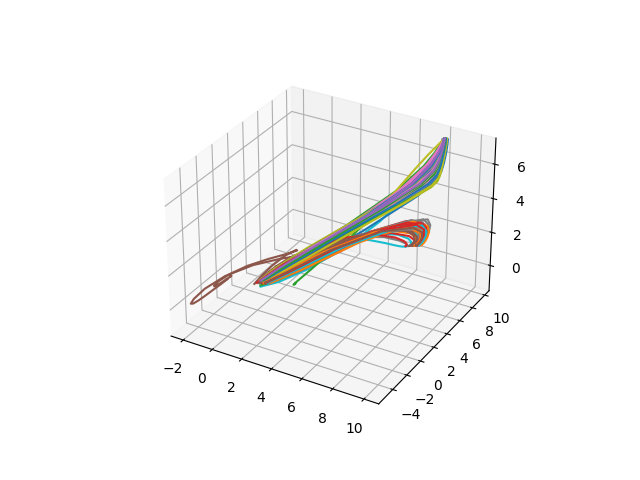

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

for ix_plot in tqdm(range(156)):
    preds = list()
    hidden_prev = torch.zeros(1, 156, hidden_size).cuda()
    for _ in range(150):
        # input_x = x[:, 0, :].reshape(156, 1, 4)  # reshape it for model feeding
        pred, hidden_prev = model(x.cuda(), hidden_prev.cuda())
        # print(pred.shape)
        # print(hidden_prev.shape)
        input_x = pred
        preds.append(pred[0, ix_plot, 0, :].detach().cpu().numpy())
    preds_3d = np.vstack(preds)

    ax.plot(preds_3d[:, 0], preds_3d[:, 1], preds_3d[:, 2])
plt.show()

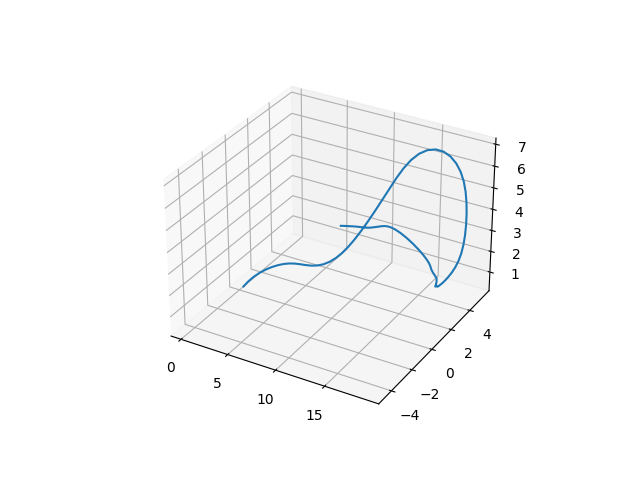

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(y[ix_plot, :, 0], y[ix_plot, :, 1], y[ix_plot, :, 2])
plt.show()

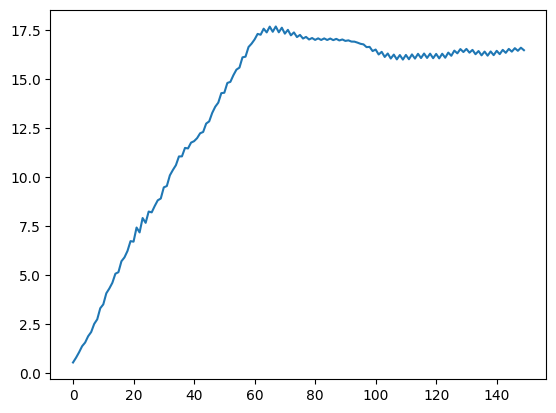

In [37]:
plt.plot(output.detach().cpu().numpy()[0, 0, :, 0])